In [12]:
import numpy as np
import numpy.linalg as npla
import matplotlib.pyplot as plt
from matplotlib import animation


from sympy import exp, sin, cos, symbols
from sympy.utilities.lambdify import lambdify

np.set_printoptions(linewidth=np.inf)

In [13]:
# accuracy and range of x, y, and t
x_i, x_f = (0,np.pi)
y_i, y_f = (0,np.pi)
t_i, t_f = (0,1)

L_x = x_f - x_i
L_y = y_f - y_i

x_points = 20
y_points = 20
t_points = 1000

# variables that will be used later
x_delta = (x_f - x_i) / (x_points - 1)
y_delta = (y_f - y_i) / (y_points - 1)
t_delta = (t_f - t_i) / (t_points - 1)

x = np.linspace(x_i, x_f, x_points)
y = np.linspace(y_i, y_f, y_points)
t = np.linspace(t_i, t_f, t_points)

nodes = x_points * y_points
nonboundary_nodes = (x_points - 2) * (y_points - 2)

# animation settings
duration = 5
animation_interval = 1000 * duration / t_points # t_points = frames
repeat_delay = 100000
cmap = 'Wistia'

In [14]:
# Convection-Diffusion Equation
xv, yv = np.meshgrid(x, y)
xt, tx = np.meshgrid(x, t)
yt, ty = np.meshgrid(y, t)
x_symbol, y_symbol, t_symbol = symbols('x y t')

# dv/dt + R * (u * ∇) u = -∇p + μ∇^2u + f
# let U = [u, v] (or [u, v, w] in 3D)
# du/dt + R * (u du/dx + v du/dy) = -dp/dx + μ(d2u/dx2 + d2u/dy2) + f_u
# dv/dt + R * (u dv/dx + v dv/dy) = -dp/dy + μ(d2v/dx2 + d2v/dy2) + f_v
# (next line is only for 3d)
# dw/dt + R * (u dw/dx + v dw/dy + w dw/dz) = -dp/dz + μ(d2w/dx2 + d2w/dy2 + d2w/dz2) + f_w
# technically there should be a density term, but I'm going to assume the density is 1 for now

# constants
mu = .1
r = 1 # in the equation it is capital R, but I want to use that variable later

# intial conditions
ui = -cos(x_symbol) * sin(y_symbol)
vi = sin(x_symbol) * cos(x_symbol)
pi = -(cos(2 * x_symbol) + cos(2 * y_symbol)) / 4

ui = np.vectorize(lambdify([x_symbol, y_symbol], ui))
vi = np.vectorize(lambdify([x_symbol, y_symbol], vi))
pi = np.vectorize(lambdify([x_symbol, y_symbol], pi))

init_x = ui(xv, yv).flatten()
init_y = vi(xv, yv).flatten()
init_p = pi(xv, yv).flatten()

# forcing function
E_x = np.vectorize(lambdify([x_symbol, y_symbol, t_symbol], 0))
E_y = np.vectorize(lambdify([x_symbol, y_symbol, t_symbol], 0))

# boundary conditions
u_x_0 = 0
u_x_L = 0
u_y_0 = -sin(y_symbol) * exp(-2 * t_symbol)
u_y_L = sin(y_symbol) * exp(-2 * t_symbol)

v_y_0 = 0
v_y_L = 0
v_x_0 = sin(x_symbol) * exp(-2 * t_symbol)
v_x_L = -sin(x_symbol) * exp(-2 * t_symbol)

p_x_0 = -(cos(2 * x_symbol) * exp(-4 * t_symbol)) / 4
p_x_L = -(cos(2 * x_symbol) * exp(-4 * t_symbol)) / 4
p_y_0 = -(cos(2 * y_symbol) * exp(-4 * t_symbol)) / 4
p_y_L = -(cos(2 * y_symbol) * exp(-4 * t_symbol)) / 4

# convert the sympy expression objects into numpy vectorize objects so it works with the meshgrid
u_x_0 = np.vectorize(lambdify([x_symbol, t_symbol], u_x_0))
u_x_L = np.vectorize(lambdify([x_symbol, t_symbol], u_x_L))
u_y_0 = np.vectorize(lambdify([y_symbol, t_symbol], u_y_0))
u_y_L = np.vectorize(lambdify([y_symbol, t_symbol], u_y_L))

v_y_0 = np.vectorize(lambdify([y_symbol, t_symbol], v_y_0))
v_y_L = np.vectorize(lambdify([y_symbol, t_symbol], v_y_L))
v_x_0 = np.vectorize(lambdify([x_symbol, t_symbol], v_x_0))
v_x_L = np.vectorize(lambdify([x_symbol, t_symbol], v_x_L))

p_x_0 = np.vectorize(lambdify([x_symbol, t_symbol], p_x_0))
p_x_L = np.vectorize(lambdify([x_symbol, t_symbol], p_x_L))
p_y_0 = np.vectorize(lambdify([y_symbol, t_symbol], p_y_0))
p_y_L = np.vectorize(lambdify([y_symbol, t_symbol], p_y_L))

# accuracy controls for pressure evolution
l = float(x_delta ** 2 / (t_delta * sin(2 * x_delta)))
e = float(x_delta ** 3)

In [15]:
# code for generating animations

# creates the maginute scalar field from the x (u) and y (v) components
def velocity_magnitude_field(u, v):
    magnitude = lambda x, y : np.sqrt(x ** 2 + y ** 2)
    vfunc = np.vectorize(magnitude)

    return vfunc(u, v)

# assumes data has shape (t_points, x_points * y_points) 
def gen_anim(data, file_name):
    fig, ax = plt.subplots(1, 1, figsize = (6,6), subplot_kw={"projection": "3d"})

    data = np.reshape(data, (t_points, x_points * y_points))

    max_z = data.min()
    min_z = data.max()
    
    print(f"max : {max_z}, min : {min_z}")

    def animate(i):
        ax.cla()
        ax.pcolormesh(x, y, data[i][:-1,:-1], cmap = plt.get_cmap(cmap), shading='flat', vmin=min_z, vmax=max_z)
        ax.set_xlim((x_i, x_f))
        ax.set_ylim((y_i, y_f))

    anim = animation.FuncAnimation(fig, animate, frames = t_points, interval = animation_interval, blit = False, repeat_delay = repeat_delay)
    anim.save(file_name)

In [16]:
# Laplacian Matrix
fd_coeffs = {1 : [[-3/2, 2, -1/2], [-1/2, 0, 1/2], [1/2, -2, 3/2]], 2 : [[2, -5, 4, -1], [1, -2, 1], [-1, 4, -5, 2]]}
delta_powers = {1 : (1, 1, 1), 2: (3, 2, 3)}

def derivative_1d(points : int, delta : float, order = int):
    forward, central, backward = fd_coeffs[order]
    delta_power = delta_powers[order]

    mat = np.zeros((points, points))
    for i in range(1, points - 1): mat[i, i-1:i+ len(central) - 1] = [x / delta ** delta_power[1] for x in central]
    
    mat[0][0:len(forward)] = [x / delta ** delta_power[0] for x in forward]
    mat[-1][-len(backward):] = [x / delta ** delta_power[2] for x in backward]

    return mat

def derivative_2d(x_points : int, x_delta : float, y_points : int, y_delta : int, order = int):
    return np.kron(derivative_1d(y_points, y_delta, order), np.eye(x_points)) + np.kron(np.eye(y_points), derivative_1d(x_points, x_delta, order))

In [17]:
# creating the evolution matrix
# let gen_mat(u_i) = A
# A * *u = u_i
def gen_mat(u_i, x_delta, order):
    # order = 0 -> u_n -> u* (pde in x)
    # order = 1 -> u* -> u** (pde in y)

    u_test = np.zeros((x_points * y_points, x_points * y_points))
    index = 0
    for i in u_i.flatten(): u_test[index] = i

    R = r * t_delta / (2 * x_delta)
    T = t_delta * mu / (x_delta ** 2)

    if order == 0:
        R_mat = np.kron(np.eye(y_points), R * derivative_1d(x_points, x_delta, 1))
        t_mat = np.kron(np.eye(y_points), np.eye(x_points) - T * derivative_1d(x_points, x_delta, 2))
    elif order == 1:
        R_mat = np.kron(R * derivative_1d(y_points, y_delta, 1), np.eye(x_points))
        t_mat = np.kron(np.eye(x_points) - T * derivative_1d(y_points, y_delta, 2), np.eye(x_points))

    return t_mat + R_mat * u_test

In [18]:
def bp(u, v, curr_t):
    # boundary conditions for u
    u[0:x_points] = u_y_0(x, curr_t)
    u[-x_points:] = u_y_L(x, curr_t)

    index = 0
    for x_val in u_x_0(y, curr_t):
        u[index] = x_val
        index += x_points

    index = x_points - 1
    for x_val in u_x_L(y, curr_t):
        u[index] = x_val
        index += x_points

    # boundary conditions for v
    v[0:x_points] = v_y_0(x, curr_t)
    v[-x_points:] = v_y_L(x, curr_t)

    index = 0
    for x_val in v_x_0(y, curr_t):
        v[index] = x_val
        index += x_points

    index = x_points - 1
    for x_val in v_x_L(y, curr_t):
        v[index] = x_val
        index += x_points

    return (u, v)

In [19]:
# restriction and prolongation matricies
P = np.zeros((nodes, nonboundary_nodes))
curr_index = 0
for i in range(nodes):
    if i > x_points and i < nodes - x_points and i % x_points not in [0,x_points-1]:
        P[i, curr_index] = 1
        curr_index += 1

R = P.transpose()
print(P.shape)
print(R.shape)

(400, 324)
(324, 400)


In [20]:
# evolves u_i to u_aux
# shape of all input vectors should be (x_points * y_points, )
def gen_u_aux(u_i_x, u_i_y, curr_t):
    u_BC, v_BC = bp(np.zeros((y_points * x_points)), np.zeros((y_points * x_points)), curr_t)
    E_i_x = E_x(xv, yv, curr_t)
    E_i_y = E_y(xv, yv, curr_t)

    Ax_star = gen_mat(u_i_x, x_delta, 0)
    Ay_star = gen_mat(u_i_y, y_delta, 0)

    star_x = (P @ (npla.inv(R @ Ax_star @ P) @ (R @ (u_i_x - Ax_star @ u_BC)))) + u_BC
    star_y = (P @ (npla.inv(R @ Ay_star @ P) @ (R @ (u_i_y - Ay_star @ u_BC))))+ v_BC

    Ax_star = gen_mat(u_i_x, x_delta, 1)
    Ay_star = gen_mat(u_i_y, y_delta, 1)

    star_star_x = (P @ (npla.inv(R @ Ax_star @ P) @ (R @ ((star_x + t_delta * E_i_x.flatten()) - Ax_star @ u_BC)))) + u_BC
    star_star_y = (P @ (npla.inv(R @ Ay_star @ P) @ (R @ ((star_y + t_delta * E_i_y.flatten()) - Ay_star @ u_BC)))) + v_BC
 
    return (star_star_x, star_star_y)

In [21]:
# generate mat based on custom stencils
def custom_mat(stencils, points):
    forward_stencil, central_stencil, backward_stencil = stencils
    mat = np.zeros((points, points))
    mat[0, 0:len(forward_stencil)] = forward_stencil
    mat[-1, -len(backward_stencil):] = backward_stencil
    for i in range(1, y_points - 1): mat[i, i - 1: i + len(central_stencil) - 1] = central_stencil

    return mat

1362941284931274.5
1
1990217399.7145913
2
1.525932234099985e+24
3
1.1699535823760849e+39
4
8.970197721276694e+53
5
6.877576031296945e+68
6
5.273133718566248e+83
7
4.0429853610265014e+98
8
3.0998134130228265e+113
9
2.3766702912613507e+128
10
1.8222263474420042e+143
11
1.3971264224241875e+158
12
1.071196365355998e+173
13
8.213012328268131e+187
14
6.297031402068564e+202
15
4.828022033055819e+217
16
3.7017120073460655e+232
17
2.838154360421826e+247
18
2.1760526366167883e+262
19
1.668409986207759e+277
20
1.2791932673124855e+292
21
9.807753661657999e+306
22
nan
23
nan
24
nan
25
nan
26
nan


C:\Users\gauth\AppData\Local\Temp\ipykernel_40304\3006362665.py:45: RuntimeWarning: overflow encountered in matmul
  p = A_INV @ RHS
C:\Users\gauth\AppData\Local\Temp\ipykernel_40304\3006362665.py:45: RuntimeWarning: invalid value encountered in matmul
  p = A_INV @ RHS


TypeError: Invalid shape (400,) for image data

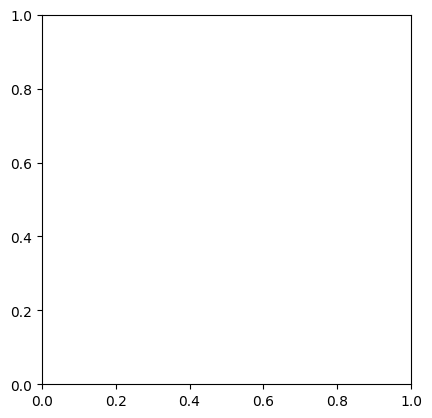

In [22]:
u = init_x
v = init_y
p = init_p

u_mat = np.zeros((t_points, x_points * y_points))
v_mat = np.zeros((t_points, x_points * y_points))
p_mat = np.zeros((t_points, x_points * y_points))

index = 0

T_x = -t_delta / (2 * x_delta)
T_y = -t_delta / (2 * y_delta)

C_x = np.kron(np.eye(y_points), derivative_1d(x_points, x_delta, 1))
C_y = np.kron(derivative_1d(y_points, y_delta, 1), np.eye(x_points))

pStencil = [[-3/4, 2, -1/2], [-1/2, 0, 1], [1/2, -2, 3/4]]
pprimeStencil = [[-3/4], [-1/2], [3/4]]

A_px = T_x * np.kron(np.eye(y_points), custom_mat(pStencil, x_points))
A_py = T_y * np.kron(custom_mat(pStencil, y_points), np.eye(x_points))
A_px_prime = T_x * np.kron(np.eye(y_points), custom_mat(pprimeStencil, x_points))
A_py_prime = T_y * np.kron(custom_mat(pprimeStencil, y_points), np.eye(x_points))

A = 1 + l * (C_x @ A_px_prime + C_y @ A_py_prime)
A_INV = npla.inv(A)

print(A_INV.max()) # this value is really big, so I think there might have been some error here?

for curr_t in t[:-1]:
    u_aux, v_aux = gen_u_aux(u, v, curr_t)

    pThresh = False

    i = 0

    while not pThresh:
        # this part of the code is incomplete, but this is where I would recursively solve equation 4b and 4c to get better and better approximations for p and u
        BX = u_aux + A_px @ p
        BY = v_aux + A_py @ p

        old_p = p

        RHS = p - l * (C_x @ BX + C_y @ BY)
        p = A_INV @ RHS

        if np.max(abs(p - old_p)) <= e: 
            pThresh = True

            u = BX + A_px_prime @ p
            v = BY + A_py_prime @ p
        
        print(i := i + 1)
        print(np.max(abs(p - old_p))) # if this increases, p does not converge

        if i > 25: 
            plt.spy(abs(p - old_p) <= e)
            raise Exception("p does not converge")
    
    print(curr_t)
    u_mat[index] = u.flatten()
    v_mat[index] = v.flatten()
    p_mat[index] = p.flatten()

    index += 1
    
mag = velocity_magnitude_field(u_mat, v_mat)

gen_anim(mag, 'tmp/velocity_field.gif')
gen_anim(p_mat, 'tmp/pressure_field.gif')